<a href="https://colab.research.google.com/github/costpetrides/FAIRMODE-WG5/blob/main/Python/Ordinary_kriging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install pykrige

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 979.6/979.6 kB 18.4 MB/s eta 0:00:00


In [2]:
pip install netCDF4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 46.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 30.3 MB/s eta 0:00:00


In [3]:
pip install cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 61.9 MB/s eta 0:00:00


In [4]:
import numpy as np
import pandas as pd
import xarray as xr
from pykrige.ok import OrdinaryKriging
from tqdm import tqdm
import time
from joblib import Parallel, delayed

# Start Timer
start_time = time.time()

# Load Data
print("Loading data...")
data = pd.read_csv('basePM25nearest_grid.csv')
model_data = xr.open_dataset('BaseCase_PERT_PM25_rh50_YEARLY.nc')

# Extract Model Data
model_lons = model_data['lon'].values
model_lats = model_data['lat'].values
model_values = model_data['SURF_ug_PM25_rh50'].values[0].astype(np.float32)  # Use float32 to reduce memory usage

# Extract Station Data
stations_data = data[['lon', 'lat', 'SURF_ug_PM25_rh50']].copy()
stations_data['nearest_SURF_ug_PM25_rh50'] = data['nearest_SURF_ug_PM25_rh50']

# Compute Bias
stations_data['bias'] = stations_data['SURF_ug_PM25_rh50'] - stations_data['nearest_SURF_ug_PM25_rh50']

# Optimized Kriging Model Selection with Parallel Processing
def evaluate_kriging_model(model, lon, lat, values):
    try:
        OK = OrdinaryKriging(lon, lat, values, variogram_model=model, verbose=False, enable_plotting=False)
        _, error = OK.execute('grid', np.linspace(lon.min(), lon.max(), 20), np.linspace(lat.min(), lat.max(), 20))
        return model, np.nanmean(error)
    except:
        return model, float('inf')

print("Selecting the best Kriging model using limited parallel processing...")
models = ['spherical', 'linear', 'exponential', 'gaussian']
results = Parallel(n_jobs=4)(delayed(evaluate_kriging_model)(model, stations_data['lon'].values, stations_data['lat'].values, stations_data['bias'].values) for model in models)
best_model = min(results, key=lambda x: x[1])[0]
print(f"Best selected variogram model: {best_model}")

# Function for Block Kriging with Shape Padding
def kriging_block(lon_range, lat_range, stations_data, best_model, shape):
    OK_bias = OrdinaryKriging(
        stations_data['lon'].values,
        stations_data['lat'].values,
        stations_data['bias'].values,
        variogram_model=best_model,
        verbose=False,
        enable_plotting=False
    )
    z_bias, _ = OK_bias.execute('grid', lon_range, lat_range)

    # Ensure all blocks have the same shape
    padded_bias = np.full(shape, np.nan, dtype=np.float32)  # Fill missing values with NaN
    padded_bias[:z_bias.shape[0], :z_bias.shape[1]] = z_bias
    return padded_bias

# Define Grid Blocks for Parallel Execution
num_blocks = 4  # Number of blocks to divide grid into
lon_splits = np.array_split(model_lons, num_blocks)
lat_splits = np.array_split(model_lats, num_blocks)

# Find max block shape for padding
max_rows = max(len(lat) for lat in lat_splits)
max_cols = max(len(lon) for lon in lon_splits)
block_shape = (max_rows, max_cols)

print("Interpolating bias using parallel Block Kriging with real-time progress...")
progress_bar = tqdm(total=num_blocks**2, desc="Kriging Progress", position=0, leave=True)

# Perform Block Kriging in Parallel
results = []
for i in range(num_blocks):
    row_blocks = []
    for j in range(num_blocks):
        row_blocks.append(kriging_block(lon_splits[j], lat_splits[i], stations_data, best_model, block_shape))
        progress_bar.update(1)  # Update progress bar in the main process
    results.append(row_blocks)
progress_bar.close()

# Concatenate blocks properly
z_bias = np.vstack([np.hstack(row) for row in results])

# Trim the final result to match the original shape
z_bias = z_bias[:len(model_lats), :len(model_lons)]

# Apply Bias Correction
print("Applying bias correction to model data...")
corrected_values = model_values + z_bias
corrected_data = model_data.copy()
corrected_data['SURF_ug_PM25_rh50_corrected'] = (['time', 'lat', 'lon'], corrected_values[np.newaxis, :, :])

# Save Corrected Data
print("Saving corrected NetCDF file...")
corrected_data.to_netcdf('BC_PERT_PM25_rh50_Y_OK.nc')

# End Timer
end_time = time.time()
print(f"Total execution time: {end_time - start_time:.2f} seconds")


Loading data...
Selecting the best Kriging model using limited parallel processing...
Best selected variogram model: spherical
Interpolating bias using parallel Block Kriging with real-time progress...


Kriging Progress: 100%|██████████| 16/16 [06:37<00:00, 24.85s/it]


Applying bias correction to model data...
Saving corrected NetCDF file...
Total execution time: 423.58 seconds


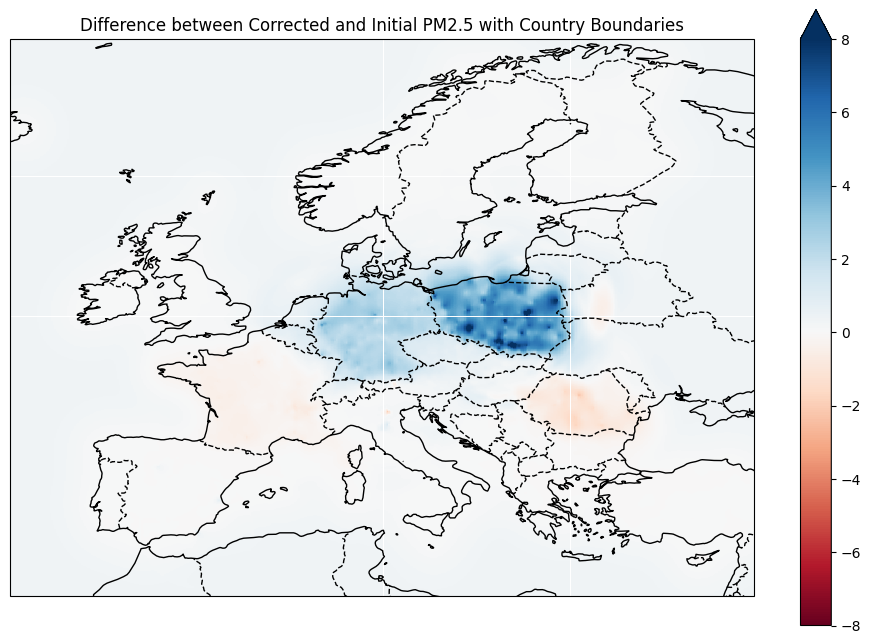

In [17]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Load the initial and corrected datasets
initial_ds = xr.open_dataset('BaseCase_PERT_PM25_rh50_YEARLY.nc')
corrected_ds = xr.open_dataset('BC_PERT_PM25_rh50_Y_OK.nc')

# Extract the PM2.5 variables (assuming time is the first dimension)
initial_pm25 = initial_ds['SURF_ug_PM25_rh50'].isel(time=0)
corrected_pm25 = corrected_ds['SURF_ug_PM25_rh50_corrected'].isel(time=0)

# Compute the difference between corrected and initial values
difference = corrected_pm25 - initial_pm25

# Define colorbar limits (adjust these values as needed)
cbar_min = -8  # minimum value for colorbar
cbar_max = 8   # maximum value for colorbar

# Create a plot with country boundaries using Cartopy
plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot the difference. Note: the robust parameter is removed to use the specified vmin and vmax.
im = difference.plot(ax=ax,
                     transform=ccrs.PlateCarree(),
                     cmap='RdBu',
                     vmin=cbar_min,
                     vmax=cbar_max,
                     add_colorbar=True)

# Add country borders and coastlines
ax.add_feature(cfeature.BORDERS, linestyle='--', edgecolor='black', linewidth=1)
ax.coastlines(resolution='50m', linewidth=1)

# Optional: set extent if you want to zoom in on a specific region
# ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())

plt.title('Difference between Corrected and Initial PM2.5 with Country Boundaries')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


# Advanced